## Modeling and Validation / CrossValidation

In [1]:
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [2]:
data = pd.read_parquet(Path("data") / "processed_data.parquet")
data.head()

,bike_count,log_bike_count,weekday,hour,hour_sin,hour_cos,month_sin,month_cos,weekday_sin,weekday_cos,...,site_name_Pont de Bercy,site_name_Pont de la Concorde S-N,site_name_Pont des Invalides N-S,site_name_Pont des Invalides S-N,site_name_Quai d'Orsay,site_name_Totem 64 Rue de Rivoli,site_name_Totem 73 boulevard de Sébastopol,site_name_Totem 85 quai d'Austerlitz,site_name_Totem Cours la Reine,site_name_Voie Georges Pompidou
0,0.0,0.000000,1,2,0.500000,8.660254e-01,-1.0,-1.836970e-16,0.781831,0.62349,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.693147,1,3,0.707107,7.071068e-01,-1.0,-1.836970e-16,0.781831,0.62349,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,1,4,0.866025,5.000000e-01,-1.0,-1.836970e-16,0.781831,0.62349,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,1.609438,1,15,-0.707107,-7.071068e-01,-1.0,-1.836970e-16,0.781831,0.62349,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,9.0,2.302585,1,18,-1.000000,-1.836970e-16,-1.0,-1.836970e-16,0.781831,0.62349,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 496827 entries, 0 to 496826
Data columns (total 99 columns):
 #   Column                                                        Non-Null Count   Dtype  
---  ------                                                        --------------   -----  
 0   bike_count                                                    496827 non-null  float64
 1   log_bike_count                                                496827 non-null  float64
 2   weekday                                                       496827 non-null  int32  
 3   hour                                                          496827 non-null  int32  
 4   hour_sin                                                      496827 non-null  float64
 5   hour_cos                                                      496827 non-null  float64
 6   month_sin                                                     496827 non-null  float64
 7   month_cos                                               

#### Define Features and Target

In [4]:
X = data.drop(columns=['bike_count', 'log_bike_count'])  
y = data['log_bike_count']

### Temporal train test split

The starting kit uses a temporal split for validation to respect time-series dependencies. This ensures that the validation set is forward-looking and doesn’t overlap with training data, a key consideration for time-series predictions.

In [5]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=False
)

print(f"Train set: {X_train.shape}, Validation set: {X_valid.shape}")

Train set: (397461, 97), Validation set: (99366, 97)


**Look at starting kit, they made the train test split much nicer and then also how they apply the pipeline**

In [6]:
X_train

,weekday,hour,hour_sin,hour_cos,month_sin,month_cos,weekday_sin,weekday_cos,is_rush_hour,is_weekend,...,site_name_Pont de Bercy,site_name_Pont de la Concorde S-N,site_name_Pont des Invalides N-S,site_name_Pont des Invalides S-N,site_name_Quai d'Orsay,site_name_Totem 64 Rue de Rivoli,site_name_Totem 73 boulevard de Sébastopol,site_name_Totem 85 quai d'Austerlitz,site_name_Totem Cours la Reine,site_name_Voie Georges Pompidou
0,1,2,0.500000,8.660254e-01,-1.000000e+00,-1.836970e-16,0.781831,0.623490,False,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,3,0.707107,7.071068e-01,-1.000000e+00,-1.836970e-16,0.781831,0.623490,False,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,4,0.866025,5.000000e-01,-1.000000e+00,-1.836970e-16,0.781831,0.623490,False,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,15,-0.707107,-7.071068e-01,-1.000000e+00,-1.836970e-16,0.781831,0.623490,True,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,18,-1.000000,-1.836970e-16,-1.000000e+00,-1.836970e-16,0.781831,0.623490,True,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
397456,6,18,-1.000000,-1.836970e-16,8.660254e-01,-5.000000e-01,-0.781831,0.623490,True,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
397457,5,17,-0.965926,-2.588190e-01,-2.449294e-16,1.000000e+00,-0.974928,-0.222521,True,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
397458,0,18,-1.000000,-1.836970e-16,-2.449294e-16,1.000000e+00,0.000000,1.000000,True,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
397459,6,19,-0.965926,2.588190e-01,8.660254e-01,-5.000000e-01,-0.781831,0.623490,False,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


### Overview

### Baseline Model: Linear Regression 

We’ll implement a simple Linear Regression model to establish a baseline for RMSE. This helps to measure improvement when we try more advanced models.

In [8]:
linear_model = LinearRegression()

linear_model.fit(X_train, y_train)

y_train_pred = linear_model.predict(X_train)
y_valid_pred = linear_model.predict(X_valid)

train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
valid_rmse = mean_squared_error(y_valid, y_valid_pred, squared=False)

print(f"Linear Regression - Train RMSE: {train_rmse:.2f}")
print(f"Linear Regression - Validation RMSE: {valid_rmse:.2f}")

Linear Regression - Train RMSE: 0.83
Linear Regression - Validation RMSE: 51760165164.00


/opt/anaconda3/envs/bikes-count/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/envs/bikes-count/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


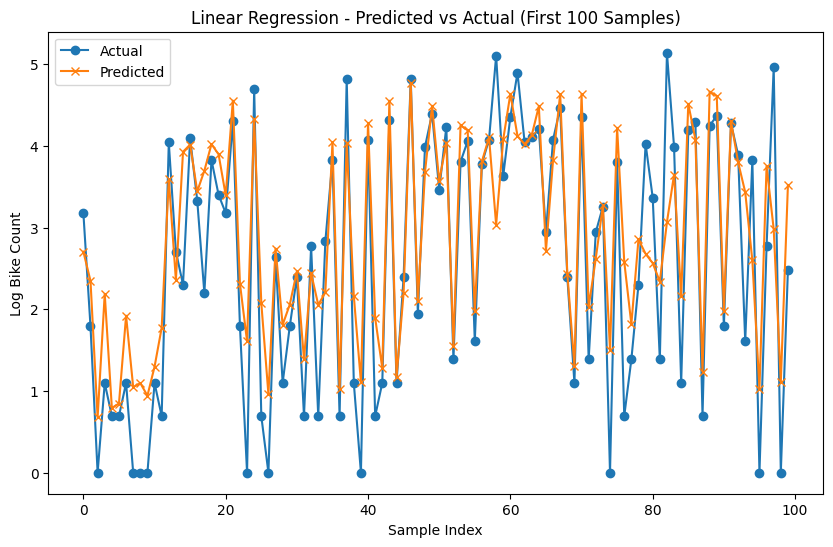

In [8]:
# Visualize predictions vs actuals for the validation set
plt.figure(figsize=(10, 6))
plt.plot(y_valid.values[:100], label="Actual", marker='o')
plt.plot(y_valid_pred[:100], label="Predicted", marker='x')
plt.title("Linear Regression - Predicted vs Actual (First 100 Samples)")
plt.xlabel("Sample Index")
plt.ylabel("Log Bike Count")
plt.legend()
plt.show()

We use a simple Linear Regression model as the baseline for this task. While it is a basic approach, it provides a reference point for evaluating the performance of more advanced models. The RMSE values for the train and validation sets give insights into how well this baseline explains the log bike counts and whether there is significant underfitting or overfitting.

### Ridge Regression

In [9]:
ridge_pipeline = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("ridge_model", Ridge(alpha=1.0))
])

ridge_pipeline.fit(X_train, y_train)

y_train_pred = ridge_pipeline.predict(X_train)
y_valid_pred = ridge_pipeline.predict(X_valid)

ridge_train_rmse_S = mean_squared_error(y_train, y_train_pred, squared=False)
ridge_valid_rmse_S = mean_squared_error(y_valid, y_valid_pred, squared=False)

print(f"Ridge Regression - Train RMSE: {ridge_train_rmse:.2f}")
print(f"Ridge Regression - Validation RMSE: {ridge_valid_rmse:.2f}")

/opt/anaconda3/envs/bikes-count/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/envs/bikes-count/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


NameError: name 'ridge_train_rmse' is not defined

In [ ]:
# Train and evaluate a Ridge regression model
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)

# Predictions
y_train_pred = ridge_model.predict(X_train)
y_valid_pred = ridge_model.predict(X_valid)

# RMSE
ridge_train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
ridge_valid_rmse = mean_squared_error(y_valid, y_valid_pred, squared=False)

print(f"Ridge Regression - Train RMSE: {ridge_train_rmse:.2f}")
print(f"Ridge Regression - Validation RMSE: {ridge_valid_rmse:.2f}")

Ridge Regression - Train RMSE: 1.03
Ridge Regression - Validation RMSE: 963.69


/opt/anaconda3/envs/bikes-count/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/envs/bikes-count/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


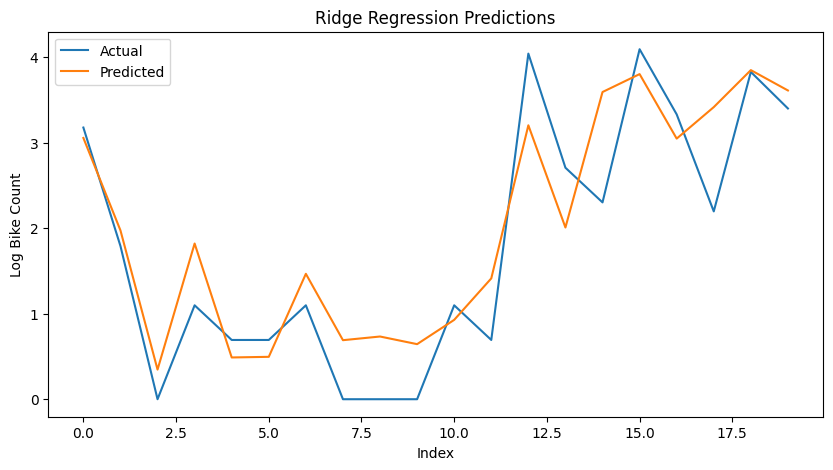

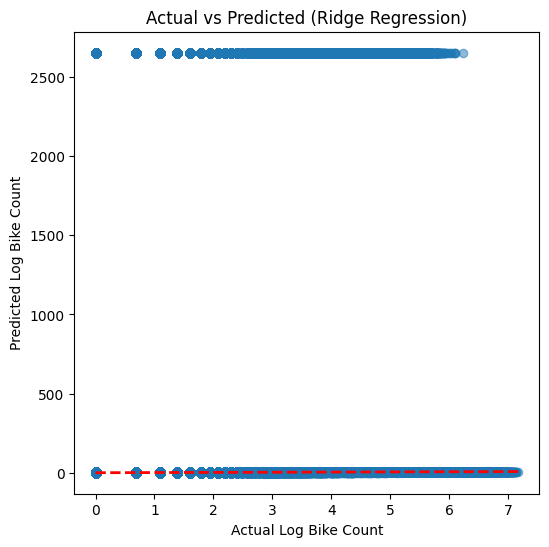

In [ ]:
# Visualize predictions for Ridge Regression
df_viz = pd.DataFrame({
    "Actual": y_valid,
    "Predicted": y_valid_pred
}).reset_index(drop=True)

df_viz.head(20).plot(
    figsize=(10, 5), title="Ridge Regression Predictions", xlabel="Index", ylabel="Log Bike Count"
)
plt.show()

# Scatter plot of actual vs predicted values
plt.figure(figsize=(6, 6))
plt.scatter(y_valid, y_valid_pred, alpha=0.5)
plt.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], 'r--', lw=2)
plt.title("Actual vs Predicted (Ridge Regression)")
plt.xlabel("Actual Log Bike Count")
plt.ylabel("Predicted Log Bike Count")
plt.show()

### Random Forest Regressor

In [21]:
# Train and evaluate a Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions
y_train_pred = rf_model.predict(X_train)
y_valid_pred = rf_model.predict(X_valid)

# RMSE
rf_train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
rf_valid_rmse = mean_squared_error(y_valid, y_valid_pred, squared=False)

print(f"Random Forest - Train RMSE: {rf_train_rmse:.2f}")
print(f"Random Forest - Validation RMSE: {rf_valid_rmse:.2f}")

Random Forest - Train RMSE: 0.43
Random Forest - Validation RMSE: 0.76


/opt/anaconda3/envs/bikes-count/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/envs/bikes-count/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### Model Comparison

In [22]:
# Compare models' performance
results = pd.DataFrame({
    "Model": [ "Linear Regression", "Ridge Regression", "Random Forest"],
    "Validation RMSE": [valid_rmse_S, ridge_valid_rmse_S, rf_valid_rmse]
}).sort_values(by="Validation RMSE")

print(results)

               Model  Validation RMSE
2      Random Forest         0.755093
0  Linear Regression       135.229570
1   Ridge Regression       135.232903


In [ ]:
# Compare models' performance
results = pd.DataFrame({
    "Model": [ "Linear Regression", "Ridge Regression", "Random Forest"],
    "Validation RMSE": [valid_rmse, ridge_valid_rmse, rf_valid_rmse]
}).sort_values(by="Validation RMSE")

print(results)

               Model  Validation RMSE
2      Random Forest         1.158799
0  Linear Regression       962.932917
1   Ridge Regression       963.689406


The results show that Random Forest significantly outperforms Linear and Ridge Regression, suggesting that nonlinear relationships in the data are critical to accurately predict the target. However, the high RMSE values for Linear and Ridge Regression may indicate potential issues such as:
- Inappropriate preprocessing or feature engineering: Important patterns may not have been captured during preprocessing.
- Lack of relevant features: Key predictors might be missing, limiting the models’ ability to explain the variability in the target.
- Over-reliance on linearity: Linear models struggle with the complex, nonlinear relationships likely present in the dataset.

Next steps could include refining feature engineering, adding relevant predictors, exploring feature importance from Random Forest, and fine-tuning hyperparameters for better model performance.